## Packages

In [3]:
from scipy.integrate import odeint, quad
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

## Reaction and Background

This will be simulating the product of Acetic Anhydride. The a possible reaction mechanism is shown as follows:

In a PFR:
$$\text{Acetone} \rightarrow \text{Ketene} + \text{Methane}$$
$$\text{Ketene} \rightarrow \text{Carbon Monoxide} + \text{Ethylene}$$

In a CSTR:
$$\text{Ketene} + \text{Acetic Acid} \rightarrow \text{Acetic Anhydride}$$

The following is in chemical formulas:

In a PFR:
$$C_3 H_6O \rightarrow C_2H_2O + CH_4$$
$$C_2 H_2O \rightarrow CO + \frac{1}{2} C_2H_4$$

In a CSTR:
$$C_2 H_2O + C_2H_4O_2 \rightarrow C_4H_6O_3$$


And these are the apprevations that will be used:
$$A \rightarrow B + C$$
$$B \rightarrow D + \frac{1}{2}E$$

$$B + F \rightarrow G$$

There are 3 main by-products in this reaction; Methane, Carbon Monoxide, and Ethylene. 
The trick here is to get as much Ketene as possible in the first reaction but not produce a lot of $CO$ and $C_2H_4$
This will allow us to maximize the outlet concentration of Acetic Anhydride

The two feeds are Acetone and Acetic Acid.

<img src='PFD3.png'>

## Physics Base Model

In [4]:
def CSTR(y, t, Ca_f, Ta_f, v̇, Vr, Tc):
    Ca, Cb, Cc, Cd, Ce, T = y
    
    Na, Nb, Nc, Nd, Ne  = Ca*Vr, Cb*Vr, Cc*Vr, Cd*Vr, Ce*Vr
     
    
    def Cps(T, A, B, C, D, E, F, G):
        return A + B*(((C/T)**2*np.exp(C/T))/(np.exp(C/T) -1)**2) + D*(((E/T)**2*np.exp(E/T))/(np.exp(E/T) -1)**2) + F*(((G/T)**2*np.exp(G/T))/(np.exp(G/T) -1)**2)
    
    def Cp(T, A, B, C, D, E):
        return A + B*(C/T/(np.sinh(C/T)))**2 + D*(E/T/(np.cosh(E/T)))**2
    
    coeff_a = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
    coeff_b = [36940, 68650, 1490, 45240, 640]
    coeff_c = [33298, 79933, 2086.9, 41602, 991.96]
    coeff_d = [29108, 8773, 3085.1, 8455.3, 1538.2]
    coeff_e = [33380, 94790, 1596, 55100, 740.8]
    
    Cpa = Cps(T, *coeff_a)
    Cpb = Cp(T, *coeff_b)
    Cpc = Cp(T, *coeff_c)
    Cpd = Cp(T, *coeff_d)
    Cpe = Cp(T, *coeff_e)
    
#     Cpa = 161.48 # kJ/kmol
#     Cpb = 83.143
#     Cpc = 71.66
#     Cpd = 33.027
#     Cpe = 93.588
 
    #---- Kinetics ----#
    
    def k(A, Ea, T):
        R = 8.314 # J/mole-K
        return A*np.exp(-Ea/(R*T))
    
    A_1 = 8.2e14
    Ea_1 = 2.845e5 # J/mol
    k_1_1 = k(A_1, Ea_1, T)
    
    A_2 = 1.7e17
    Ea_2 = 3.259e5 # J/mol
    k_2_1 = k(A_2, Ea_2, T)
    
    ra_1 = k_1_1*Ca
    rb_1 = k_2_1*Cb
    
    Ua = 1.64e6
    
    
    
    #---- Thermodynamics ----#
    
    Hr_a = -2.4700e5 # kJ/kmol
    Hr_b = -47500
    Hr_c = -74520
    Hr_d = -1.1053e5
    Hr_e = 52510
    
#     ΔHr_1 = lambda T: (Hr_c + Hr_b - Hr_a) + quad(lambda T: Cp(T, *coeff_c) + Cp(T, *coeff_b)\
#                                                  -Cps(T, *coeff_a), 298.15, T)[0]
#     ΔHr_2 = lambda T:(.5*Hr_e + Hr_d - Hr_b) + quad(lambda T: .5*Cp(T, *coeff_e) + Cp(T, *coeff_d)\
#                                                  -Cp(T, *coeff_b), 298.15, T)[0]
    
    ΔHr_1 = (Hr_c + Hr_b - Hr_a) + (Cpc + Cpb -Cpa)*(T - 298.15)
    ΔHr_2 = (.5*Hr_e + Hr_d - Hr_b) + (.5*Cpe + Cpd -Cpb)*(T - 298.15)
    
    #---- Equations ----#
    
    
    
    dCadt = v̇*(Ca_f - Ca)/Vr - ra_1
    dCbdt = v̇*(0    - Cb)/Vr + ra_1 - rb_1
    dCcdt = v̇*(0    - Cc)/Vr + ra_1
    dCddt = v̇*(0    - Cd)/Vr + rb_1
    dCedt = v̇*(0    - Ce)/Vr + .5*rb_1
    
#     dTdt = (Ua*(Tc - T) - (v̇*Ca_f)*Cpa(T)*(T - Ta_f) - ra_1*ΔHr_1(T) - rb_1*ΔHr_2(T))/\
#             (Na*Cpa(T) + Nb*Cpb(T) + Nc*Cpc(T) + Nd*Cpd(T) + Ne*Cpe(T))
    
    dTdt = (Ua*(Tc - T) - (v̇*Ca_f)*Cpa*(T - Ta_f) - ra_1*ΔHr_1 - rb_1*ΔHr_2)/\
            (Na*Cpa + Nb*Cpb + Nc*Cpc + Nd*Cpd + Ne*Cpe)
    
    
    equations = np.array([dCadt, dCbdt, dCcdt, dCddt, dCedt, dTdt])
    return equations

## Simulation

Goal is to maximize Ketene and minimize Methane, Carbon Monoxide, and Ethylene


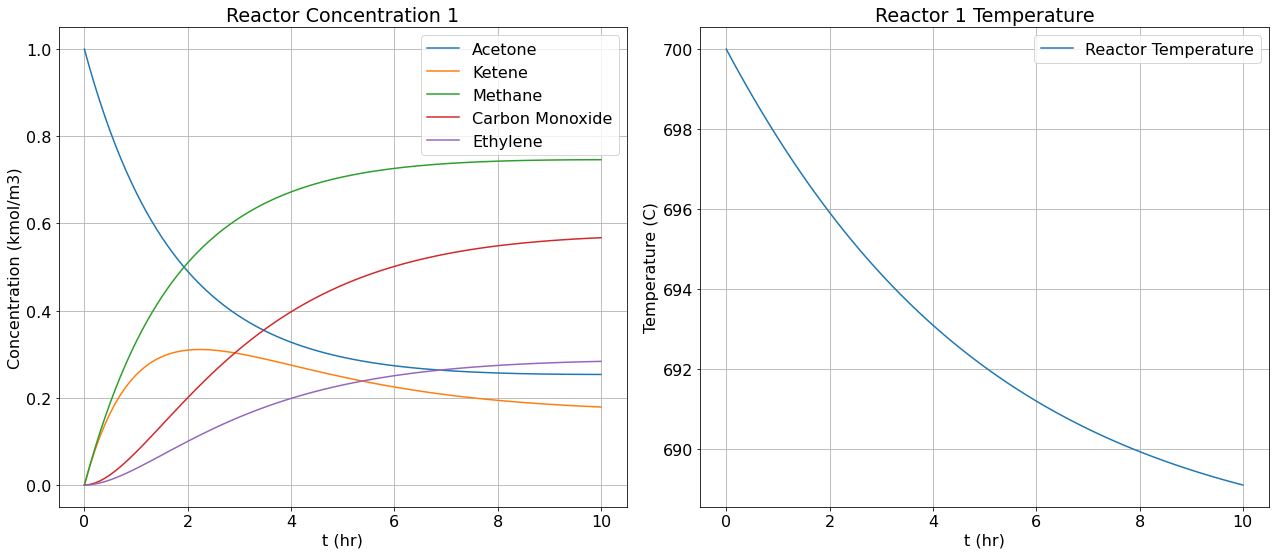

In [8]:
#---- Parameters ----#

# Inlet Conditions
Ca_f = 1 # kmol/hr
Ta_f = 700 + 273.15


Vr = 100 # m3
v̇ = 10 # m3/hr
Tc = 675 + 273.15# kJ/hr

# Initial Conditions
Ca_0 = 1
T_0 = 700 + 273.15


initials = [Ca_f, 0, 0, 0, 0, T_0]
t = np.linspace(0, 10, 101)

Ca, Cb, Cc, Cd, Ce, T = odeint(CSTR, initials, t, args=(Ca_f, Ta_f, v̇, Vr, Tc)).T

plotsize=(18,8)
fontsize=16
print('Goal is to maximize Ketene and minimize Methane, Carbon Monoxide, and Ethylene')

plt.figure(1, figsize=plotsize)
plt.rc('font', size=fontsize)

plt.subplot(1,2,1)
plt.plot(t, Ca, label='Acetone')
plt.plot(t, Cb, label='Ketene')
plt.plot(t, Cc, label='Methane')
plt.plot(t, Cd, label='Carbon Monoxide')
plt.plot(t, Ce, label='Ethylene')
plt.ylabel('Concentration (kmol/m3)')
plt.title('Reactor Concentration 1')
plt.xlabel('t (hr)')
plt.legend(loc='best')
plt.grid()

         
plt.subplot(1,2,2)
plt.plot(t,T-273.15, label='Reactor Temperature')
plt.xlabel('t (hr)')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')
plt.title('Reactor 1 Temperature')
plt.grid()

plt.tight_layout()
plt.show()

## Step Test

Volume = 20

Volume = 40

Volume = 60

Volume = 80

Volume = 100



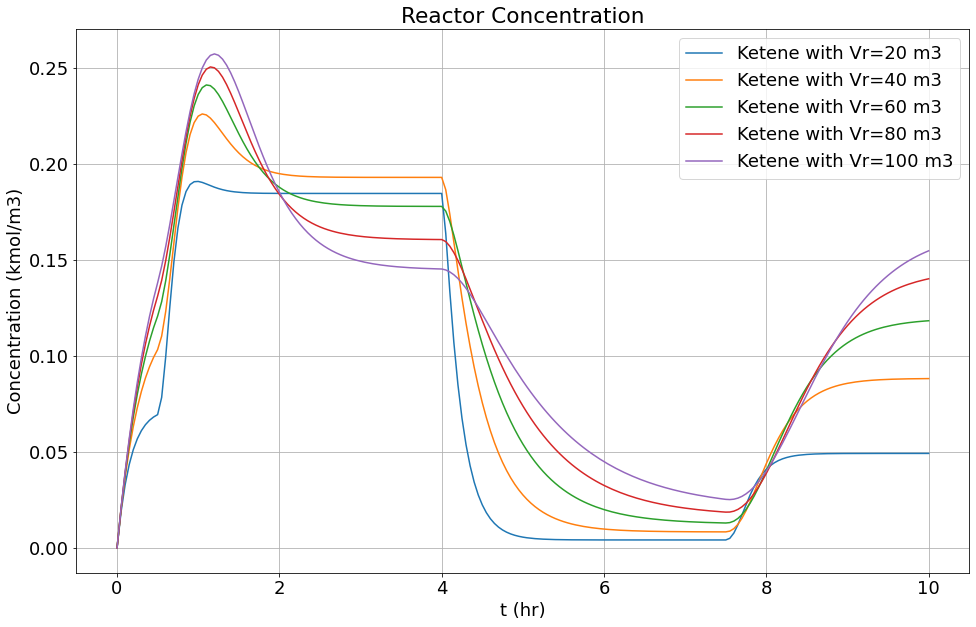

In [51]:
# Parameters
Ca_f = 1 # kmol/hr
Ta_f = 700 + 273.15
Tc_0 = 700 + 273.15
Vr = 150 # m3
for Vr in range(20, 101, 20):

    #v̇ = 50 # m3/hr
    print(f'Volume = {Vr}')

    x0 = [Ca_f, 0, 0, 0, 0, 700+273.15]
    t = np.linspace(0, 10, 201)

    Ca_arr = np.ones(len(t))*Ca_f
    Cb_arr = np.zeros(len(t))
    Cc_arr = np.zeros(len(t))
    Cd_arr = np.zeros(len(t))
    Ce_arr = np.zeros(len(t))
    T_arr = np.ones(len(t)) * Ta_f
    SP = np.ones(len(t))
    Tc_u = np.ones(len(t)) * Tc_0

    Tc_u[10:80] = 800 + 273.15
    Tc_u[80:150] = 550 + 273.15
    Tc_u[150:] = 675 + 273.15

    for i in range(len(t)-1):
        ts = [t[i],t[i+1]]
        y = odeint(CSTR,x0,ts,args=(Ca_f,Ta_f,v̇,Vr,Tc_u[i]))
        Ca_arr[i+1] = y[-1][0]
        Cb_arr[i+1] = y[-1][1]
        Cc_arr[i+1] = y[-1][2]
        Cd_arr[i+1] = y[-1][3]
        Ce_arr[i+1] = y[-1][4]
        T_arr[i+1]  = y[-1][5]

        x0[0] = Ca_arr[i+1]
        x0[1] = Cb_arr[i+1]
        x0[2] = Cc_arr[i+1]
        x0[3] = Cd_arr[i+1]
        x0[4] = Ce_arr[i+1]
        x0[5] = T_arr[i+1]

    plotsize=(16,10)
    fontsize=18

    plt.figure(1, figsize=plotsize)
    plt.rc('font', size=fontsize)

    #plt.subplot(3,1,1)
    #plt.plot(t, Ca_arr, label='Acetone')
    plt.plot(t, Cb_arr, label=f'Ketene with Vr={Vr} m3')
    #plt.plot(t, Cc_arr, label='Methane')
    #plt.plot(t, Cd_arr, label='Carbon Monoxide')
    #plt.plot(t, Ce_arr, label='Ethylene')
    plt.ylabel('Concentration (kmol/m3)')
    plt.title('Reactor Concentration')
    plt.xlabel('t (hr)')
    plt.legend(loc='best')
    plt.grid()


#     plt.subplot(3,1,2)
#     plt.plot(t,T_arr-273.15, label='Reactor Temperature')
#     plt.xlabel('t (hr)')
#     plt.ylabel('Temperature (C)')
#     plt.legend(loc='best')
#     plt.title('Reactor Temperature')
#     plt.grid()

#     plt.subplot(3,1,3)
#     plt.plot(t, Tc_u - 273.15, 'k--', label='Reactor Heat Control')
#     plt.xlabel('t (hr)')
#     plt.ylabel('Temperature (C)')
#     plt.legend(loc='best')
#     plt.title('Reactor Coolant/Heater')
#     plt.grid()

#     plt.tight_layout()
#     plt.show()
    
    print()